<a href="https://colab.research.google.com/github/Guo-bot-1998/Appendicitis/blob/master/Appendicitis_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import

In [1]:
!pip install timm
!pip install tqdm
!pip install kora
!pip install fake_useragent

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.3 MB/s eta 0:00:00


In [2]:
import nibabel as nib
import numpy as np
import os
import pandas as pd
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import random
import re
import json
import timm
import gdown
from torch.utils.data import Dataset, DataLoader
from kora.xattr import get_id
import asyncio
import aiohttp
import nest_asyncio
from tqdm.asyncio import tqdm
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from google.colab import widgets

nest_asyncio.apply()
loop = asyncio.get_event_loop()

## 存取

In [3]:
def get_data_disk(driveroot, targetdir):
  """從雲端資料夾targetdir下載檔案到colab root底下同名資料夾
  只下載沒有下載的檔案.

  driveroot為雲端檔案資料夾root"""

  if not os.path.exists('/content/' + targetdir):
    os.makedirs(targetdir)
    print(f"making {targetdir} dir...")

  files_on_drive = os.listdir(driveroot+'/'+targetdir)
  files_in_localdir = os.listdir(f"/content/{targetdir}")
  files_to_download = [f for f in files_on_drive if f not in files_in_localdir]
  files = [(filename, get_id(f'{driveroot}/{targetdir}/{filename}')) for filename in files_to_download]


  for idx, (name, file_id) in enumerate(files):

    if not file_id:
      print(f"未找到文件: {name}")
      continue

    # 下载文件
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while not done:
      status, done = downloader.next_chunk()
      # print(f"下载 {name} 进度: {int(status.progress() * 100)}%")

    # 将文件内容写入本地文件
    local_file_path = os.path.join('/content', targetdir, name)

    with open(local_file_path, 'wb') as f:
      fh.seek(0)
      f.write(fh.read())

    print(f"{idx+1}/{len(files)}: {name} downloaded")




async def download_file(session, name, file_id, file_path, token):
  if not file_id:
    print(f"未找到文件: {name}")
    return

  download_url = f"https://www.googleapis.com/drive/v3/files/{file_id}?alt=media"
  headers = {"Authorization": f"Bearer {token}"}

  async with session.get(download_url, headers=headers) as response:
    if response.status == 200:
      with open(file_path, 'wb') as f:
        while True:
          chunk = await response.content.read(1024)
          if not chunk:
            break
          f.write(chunk)
      # print(f"Downloaded: {name}...")
    else:
      print(f"Failed: {name}!! status: {response.status}")


# 定义异步获取数据的主函数
async def get_data_disk_async(driveroot, targetdir, token):
  # 生成文件夹的绝对路径
  drive_folder_path = os.path.join(driveroot, targetdir)
  local_folder_path = os.path.join('/content', targetdir)

  if not os.path.exists(local_folder_path):
    os.makedirs(local_folder_path)
    print(f"making {targetdir} dir...")

  # 获取文件列表
  files_on_drive = os.listdir(drive_folder_path)
  files_in_localdir = os.listdir(local_folder_path)
  files_to_download = [f for f in files_on_drive if f not in files_in_localdir]
  files = [(filename, get_id(os.path.join(drive_folder_path, filename))) for filename in files_to_download]

  async with aiohttp.ClientSession() as session:
    tasks = []
    for idx, (name, file_id) in enumerate(files):
      local_file_path = os.path.join(local_folder_path, name)
      task = asyncio.create_task(download_file(session, name, file_id, local_file_path, token))
      tasks.append(task)

    # 使用 tqdm 包装任务列表以显示进度条
    for f in tqdm.as_completed(tasks, total=len(tasks)):
      await f



def process_data2(traindir, shift=0, termi=10, dropFalse=0.85, dropPos=0, files=None):
  """Reading data in "traindir" and process them.
  Taking care of memory efficiency"

  Args:
    shift: 從第幾個開始讀取 (當files給定時無效)
    termi: 讀取幾個 (當files給定時無效)
    dropFalse: 被刪除的有闌尾炎的張數比例
    dropPos: 被刪除的有闌尾炎的張數比例
    files: 要讀取的檔案id，預設是None

  Returns:
    images: 输出的图像数据
    labels: 输出的标签数据
  """

  if not files:
    filelist = os.listdir(traindir)
    filelist = filelist[shift:shift+termi]
  else: filelist = files

  return loading_data(traindir, filelist, dropFalse, dropPos)



def loading_data(traindir, filelist, dropFalse, dropPos)\
 -> tuple[torch.tensor, torch.tensor]:

  print(f"reading {traindir=}...")
  labels_ = read_label(labelpath)

  if labels_.index.name != 'id':
    labels_.set_index('id', inplace=True)

  #裁減過的圖片放在Cropped_[範圍]的資料夾下,用路徑名稱判斷資料使否裁減過
  cropmatch = re.search(r'Cropped', traindir)
  if not cropmatch:
    print("讀取未切片的資料夾")
    xlim, ylim, zlim = [0,512], [0,512], [0,None]
  else:
    #範圍 = xstart-xend_ystart-yend_zstart-zend
    ismatch = re.search(r'(\d+-\d+)_(\d+-\d+)_(\d+-\d+)', traindir)
    if ismatch:
      dimens = ismatch.group(0)
      labelidx = dimens.split('_')
      xlim = [int(idx) for idx in labelidx[0].split('-')]
      ylim = [int(idx) for idx in labelidx[1].split('-')]
      zlim = [int(idx) for idx in labelidx[2].split('-')]
      print(f"{xlim=}\n{ylim=}\n{zlim=}")
      if xlim[0] >= xlim[1] or ylim[0] >= ylim[1] or zlim[0] >= zlim[1]:
        print("切片格式不正确")
        return
    else:
      print("切片格式不正确")
      return



  # preallocated
  if not cropmatch:
    selecteds = [labels_.loc[labels_.index.str.startswith(afile.strip('.nii.gz')+'_')] for afile in filelist]
    numcuts = [len(selected) for selected in selecteds]
    numcuts = sum(numcuts)
  else:
    numcuts = (zlim[1]-zlim[0]) * len(filelist)
  images = torch.zeros(numcuts,1, ylim[-1]-ylim[0],xlim[-1]-xlim[0])
  labels = -torch.ones(numcuts)
  nimgs = 0
  nprocess = 0

  for key in filelist:
    file_path = os.path.join(traindir, key)
    key = key.strip('.nii.gz')
    scan  = labels_.loc[labels_.index.str.startswith(key+'_')]
    value = nib.load(file_path).get_fdata()

    label_t = torch.tensor(scan['label'][zlim[0]:zlim[-1]])
    image_t = torch.from_numpy(value).float().permute(2, 0, 1).unsqueeze(1)

    #有幾筆不是512x512
    if (not cropmatch) and (image_t.shape[2] != 512 or image_t.shape[3] != 512):
      image_t = cropping(image_t)

    image_t, label_t = remove_false_images(image_t, label_t, dropFalse)
    image_t, label_t = remove_positive_images(image_t, label_t, dropPos)

    n_new = len(label_t)

    images[nimgs:nimgs+n_new] = image_t
    labels[nimgs:nimgs+n_new] = label_t
    nimgs += len(label_t)
    print(f"Process {nprocess}: {key} finished...")
    nprocess += 1


  #after drop
  counts = count_zero(images)
  images = torch.asarray(images[:len(images)-counts])
  labels = labels[labels != -1]

  return images, labels.float()




def read_test(testdir,shift=0,termi=10):
  """Reading data in "testdir"
  not memory efficient
  Args:
    shift: 從第幾個開始讀取
    termi: 讀取幾個
  Returns:
    images: 输出的图像数据
    scans_info: 每個scan的檔名和切片數(原本nii檔所包含的數量)

  """


  filelist = os.listdir(testdir)
  filelist = filelist[shift:shift+termi]
  scans_info = []

  images = []
  nprocess = 0

  for key in filelist:
    file_path = os.path.join(testdir, key)
    key = key.strip('.nii.gz')
    value = nib.load(file_path).get_fdata()
    scans_info.append((key, value.shape[2]))

    image_t = torch.from_numpy(value).float().permute(2, 0, 1).unsqueeze(1)

    images.append(image_t)
    print(f"{nprocess}: Read test {key} finished...")
    nprocess += 1

  images = torch.cat(images,dim=0)
  print(f"read {len(scans_info)} scans")

  return images, scans_info




def save_model(model, modelname="", dirname="", root=os.path.realpath("/content/drive/MyDrive/AOCR2024/params")):

  if not model:
    print("not given model")
    return

  if not os.path.exists(root):
    print(f"{root} not exists!")
    return

  print(f"model will be saved as {root}/{dirname}/{modelname}")

  if not modelname:
    modelname = input("請輸入模型儲存的檔名:")
  if not dirname:
    dirname = input("請輸入模型儲存的資料夾:")

  filename = f"{root}/{dirname}/{modelname}"

  if not os.path.exists(os.path.dirname(filename)):
    os.mkdir(os.path.dirname(filename))

  if os.path.isfile(filename+'.pth'):
      print(f"{filename}.pth exist.")
  else:
      torch.save(model.state_dict(), f'{filename}.pth')

  return filename



def read_label(excel_path) -> pd.DataFrame:
  """Reads a csv file containing ground-truth.
    The csv file should have two columns: 'id' and 'label'.
  """
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    df.set_index('id', inplace=True)
    return df


def read_split(excel_path):
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    return df

def write_error(logpath, e, nprocess):
  # with open(logpath, 'a') as f:
    # f.write(f"{nprocess:} error occured: {e}\n") ##! may stuck the program!!
  print(f"{nprocess:} error occured: {e}\n")


def read_submission(excel_path) -> pd.DataFrame:
  """Reads a csv file containing submission file.
    The csv file should follow the format given by Kaggle.
  """
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    df.set_index('id', inplace=True)
    return df




## 列印結果

In [4]:
def get_confusion(guess, truth):
  if torch.is_tensor(guess):
    guess = guess.cpu().numpy()
  if torch.is_tensor(truth):
    truth = truth.cpu().numpy()

  right = guess == truth
  wrong = np.logical_not(right)
  TP = np.sum(np.logical_and(right, truth == np.ones(right.shape)))
  TN = np.sum(np.logical_and(right, truth == np.zeros(right.shape)))
  FN = np.sum(np.logical_and(wrong, truth == np.ones(wrong.shape)))
  FP = np.sum(np.logical_and(wrong, truth == np.zeros(wrong.shape)))
  return (TP,FP,FN,TN)


def get_score(TP,FP,FN,TN):
  recall = TP/(TP + FN)
  precision = TP/(TP + FP)
  recall = 0 if np.isnan(recall) else recall.item()
  precision = 0 if np.isnan(precision) else precision.item()
  F1 = 0 if recall + precision == 0 else  (2*recall*precision/(recall+precision))

  return recall, precision, F1


def print_results(prediction, labels):
  TP,FP,FN,TN = get_confusion(prediction, labels)
  print(f"\n\
      真實值\n\
  預  +-----+-----+\n\
  測| TP: {TP}| FP: {FP}|\n\
  值| FN: {FN}| TN: {TN}|\n\
      +-----+-----+ \n")
  recall, precision, F1 = get_score(TP,FP,FN,TN)

  print(f"{recall=}\n{precision=}\n{F1=}\n")

def create_tab(tabnames):
  tb = widgets.TabBar(tabnames)
  return tb


def display_train(train_info, predict_info):
  t_loss, t_accu, v_loss, v_accu = train_info
  predict_list, labels_ = predict_info

  msg = [f"Epoch  train_loss  train_accu   valid_loss  valid_accu",
    f"       recall      precision    F1"]

  print('-'*len(msg[0]))
  print(msg[0])
  print(f"{epoch:>5d}: {t_loss:<10.8f}, {t_accu:<10.8f}%, {v_loss:<10.8f}, {v_accu:<10.8f}%")
  print(msg[1])
  print(f"       {recall:<6.8f}, {precision:<11.8f}, {F1:<.8f}")
  print('-'*len(msg[0]))

## 數據裁減




In [5]:
def argumenting(images, labels, n=5):
  """
  數據增強。
  在images裡面把所有有闌尾炎的cut複製給定次數，並
  插入回images的隨機位置裡面

  Args:
    images: 输入的图像数据
    labels: 输入的标签数据
    n: 每个样本複製多少次

  Returns:
    增強后的图像数据和标签数据
  """
  where = (labels == True).nonzero(as_tuple=True)[0]
  bad_images = images[where]

  rep_imgs = bad_images.repeat(n, 1, 1, 1)
  rep_labels = torch.ones(rep_imgs.shape[0], dtype=labels.dtype)

  # import pdb
  # pdb.set_trace()
  # 隨機插入argumented圖片
  nimg = images.shape[0]
  rnd_pos = torch.randint(0, nimg, (rep_imgs.shape[0],))
  images = torch.cat((images, rep_imgs), dim=0)
  images = images[torch.argsort(torch.cat((torch.arange(nimg), rnd_pos)))]

  # 對應對置插入標籤
  labels = torch.cat((labels, rep_labels), dim=0)
  labels = labels[torch.argsort(torch.cat((torch.arange(nimg), rnd_pos)))]

  return images, labels

def remove_false_images(images, labels, ratio):
    """
    隨機在images裡面移除一定比例的無闌尾炎cut

    Args:
      images: 输入的图像数据
      labels: 输入的标签数据
      ratio: 移除的比例

    Returns:
      移除后的图像数据和标签数据
    """
    # 找出 labels == 0 的索引
    where_false = (labels == 0).nonzero(as_tuple=True)[0]
    mask = torch.ones(len(images), dtype=torch.bool)
    indices_filter = torch.randperm(len(where_false))[:int(len(where_false)*ratio)]
    mask[where_false[indices_filter]] = False
    images = images[mask]
    labels = labels[mask]

    return images, labels

def remove_positive_images(images, labels, ratio):
    # 找出 labels == 1 的索引
    where_positive = (labels == 1).nonzero(as_tuple=True)[0]
    mask = torch.ones(len(images), dtype=torch.bool)
    indices_filter = torch.randperm(len(where_positive))[:int(len(where_positive)*ratio)]
    mask[where_positive[indices_filter]] = False
    images = images[mask]
    labels = labels[mask]

    return images, labels


def k_fold_split_indices(num_samples, k=5,shuffle_=True):
  """返回geneartor for index. 省記憶體"""
  state_ = None
  if shuffle_:
    state_ = 42
  kf = KFold(n_splits=k, shuffle=shuffle_, random_state=state_)
  return ((train_index, test_index) for train_index, test_index in kf.split(range(num_samples)))


splitpath = r"/content/drive/MyDrive/AOCR2024/TrainValid_split.csv"
def get_split(splitpath=splitpath):
  dfsplit = read_split(splitpath)
  train_ids,valid_ids = (dfsplit[dfsplit['group']=='Train'])['id'].tolist(),(dfsplit[dfsplit['group']=='Valid'])['id'].tolist()
  train_ids,valid_ids = [train_id +'.nii.gz' for train_id in train_ids], [valid_id +'.nii.gz' for valid_id in valid_ids]
  return train_ids,valid_ids

## 數據處理

## 其他

In [6]:

def count_zero(images):
  count = 0
  for image in images:
    if not torch.any(image):
      count += 1
  return count

def cropping(image):
  if image.shape[2] != 512:
    start = (image.shape[2] - 512) // 2
    end = start + 512
    image = image[:, :, start:end, :]

  if image.shape[3] != 512:
    start = (image.shape[3] - 512) // 2
    end = start + 512
    image = image[:, :, :, start:end]
  return image




def custom_sort_key(val):
    parts = val.split('_')
    if len(parts) == 2 and parts[1].isdigit():
        return (parts[0], int(parts[1]))
    return (parts[0], -1)  # 使沒有_(數字)的id排最前面


def isgpu():
    """檢查是否有 CUDA 支持的 GPU"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU is available")
    else:
        device = torch.device("cpu")
        # raise("GPU not available")
    return device


In [7]:
device = isgpu()

GPU is available


# 掛載


In [8]:
from google.colab import drive
drive.mount('/content/drive/',)

Mounted at /content/drive/


In [9]:
!pwd

/content


In [10]:
drive_rootdir = "/content/drive/MyDrive/AOCR2024"
labelpath = '/content/drive/MyDrive/AOCR2024/TrainValid_ground_truth.csv'
# datadir ="Train_Valid_Image"
datadir ="Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped"


Use service account to access googledrive

In [11]:
import io
import googleapiclient.discovery
from google.auth.exceptions import TransportError
from google.oauth2.service_account import Credentials
from googleapiclient.http import MediaIoBaseDownload

DriveAPIcredentials = r"/content/drive/MyDrive/AOCR2024/creds/appendicitis-407217-c2f141040794.json"
credentials = Credentials.from_service_account_file(DriveAPIcredentials,scopes=["https://www.googleapis.com/auth/drive"])
drive_service = googleapiclient.discovery.build('drive', 'v3', credentials=credentials)

# 資料下載(非同步)

In [12]:
from google.auth.transport.requests import Request
request = Request()
credentials.refresh(request)
loop.run_until_complete(get_data_disk_async(drive_rootdir, datadir,token = credentials.token))

making Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped dir...


100%|██████████| 1000/1000 [00:36<00:00, 27.26it/s]


In [13]:
!curl ipecho.net/plain

34.90.24.47

In [14]:
len(os.listdir(datadir))

1000

Directly reading files from mounted google drive  
**unknown error**: stuck after reading 9 nii files

In [15]:
# # 測試直接從mount下載
# labelpath = '/content/drive/MyDrive/AOCR2024/TrainValid_ground_truth.csv'
# datadir ="/content/drive/MyDrive/AOCR2024/Train_Valid_Image"

# process_data2(termi=5,shift=0,dropFalse=0,dropPos=0)

In [16]:
# # 測試下載
# labelpath = '/content/drive/MyDrive/AOCR2024/TrainValid_ground_truth.csv'

# dflabel = read_label(labelpath)
# images, labels, _ =  process_data2(termi=3,shift=2,dropFalse=0,dropPos=0)

In [17]:
# s1 = labels[0:60]
# s2 = labels[60:120]
# s3 = labels[120:180]
# s2

# Dataset/Model

In [18]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, mode='train'):
        self.images = images
        self.labels = labels
        self.mode = mode

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      if self.mode == 'train' or self.mode=='valid':
        return self.images[idx], self.labels[idx]
      elif self.mode == 'test':
        return self.images[idx]

## Tsai's Model

In [19]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = DoubleConv(64, 128)
        self.down2 = DoubleConv(128, 256)
        self.down3 = DoubleConv(256, 512)
        self.down4 = DoubleConv(512, 512)

        self.avgpool = nn.AdaptiveAvgPool2d(1)  # 添加全局平均池化层
        self.fc = nn.Linear(512, out_channels)  # 添加全连接层
        self.sigmoid = nn.Sigmoid()  # 添加 Sigmoid 激活函数

    def forward(self, x):
        x = self.inc(x)
        x = self.down1(nn.MaxPool2d(2)(x))
        x = self.down2(nn.MaxPool2d(2)(x))
        x = self.down3(nn.MaxPool2d(2)(x))
        x = self.down4(nn.MaxPool2d(2)(x))

        x = self.avgpool(x)  # 应用全局平均池化
        x = torch.flatten(x, 1)  # 展平
        x = self.fc(x)  # 应用全连接层
        x = self.sigmoid(x)  # 应用 Sigmoid 激活函数
        return x

# 创建 U-Net 模型实例
unet_model = UNet(in_channels=1, out_channels=1)

## EfficiencyNetV2_m

In [20]:
model_name = "tf_efficientnetv2_m"
pretrained_model = timm.create_model(model_name, pretrained=True)

# 修改輸入通道
pretrained_model.conv_stem = nn.Conv2d(1, 24, kernel_size=3, stride=2, padding=1, bias=False)

# 修改輸出類別
num_classes = 1
pretrained_model.classifier = nn.Linear(pretrained_model.classifier.in_features, num_classes)

# 添加 Sigmoid 激活函數
pretrained_model = nn.Sequential(
    pretrained_model,
    nn.Sigmoid()
)


# 檢查模型結構
# print(pretrained_model)


model.safetensors:   0%|          | 0.00/218M [00:00<?, ?B/s]

In [21]:
def train(loader, model_, optimizer, criterion, threshold, device):
  """模型輸出值超過threshold當作陽性"""
  model_.train()
  running_loss = 0.0
  correct_count = 0
  total_count = 0

  for batch_images, batch_labels in loader:
      batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
      optimizer.zero_grad()
      outputs = model_(batch_images).squeeze()
      loss = criterion(outputs, batch_labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      predicted = (outputs > threshold).int()
      correct_count += (predicted == batch_labels).sum().item()
      total_count += batch_labels.size(0)

  epoch_loss = running_loss / len(loader)
  epoch_accuracy = 100 * correct_count / total_count

  return epoch_loss, epoch_accuracy


def valid(loader, model_, criterion, threshold, device):
  """模型輸出值超過threshold當作陽性"""
  model_.eval()
  testing_loss = 0.0
  correct = 0
  total = 0
  predict_list = torch.tensor(()).to(device)

  with torch.no_grad():
      for i, (batch_images, batch_labels) in enumerate(loader):
          batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
          outputs = model_(batch_images).squeeze()
          predicted = (outputs > threshold).int()
          loss = criterion(outputs, batch_labels)

          testing_loss += loss.item() #單個batch平均loss
          bsize = batch_labels.size(0)
          total += bsize
          correct += (predicted == batch_labels).sum().item()
          # import pdb
          # pdb.set_trace()
          predict_list = torch.concat((predict_list,predicted),0)

  valid_loss = testing_loss / len(loader) #單個epoch平均loss
  valid_accuracy = 100 * correct / total

  return valid_loss, valid_accuracy, predict_list




# 資料處理

## 二八切割

In [22]:
train_id, valid_id = get_split()
images_valid, labels_valid = process_data2(datadir, dropFalse=0, files=valid_id)
images, labels = process_data2(datadir, dropFalse=0, files=train_id)

reading traindir='Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped'...
xlim=[60, 316]
ylim=[150, 406]
zlim=[11, 71]
Process 0: Zx015DF8E20804DB94E24A9B2D9DD387A47EF1C620A02026DC finished...
Process 1: Zx01F90B532F87127DB647612B6621F2065CA58692B921CEB4 finished...
Process 2: Zx0494BD052F6F8D5A583699BBC329C318AC7B5BE50FD9ACDA finished...
Process 3: Zx0800DE5C96380322C65ABA398FC93B5CBDF75B20B11DDF6E finished...
Process 4: Zx09972B8FA6215EEC75DB4194B16C000F47B5F87AFB64A12B finished...
Process 5: Zx0A1564C092259CD377329E07006281E876D09F9B48E77002 finished...
Process 6: Zx0AE5424009C101F7422C5BD9DD2C3B0E13E834114A32883A finished...
Process 7: Zx0BA755CD6D068378215FE1AE4751945053ED5D2F2C2A40E7 finished...
Process 8: Zx0CA5CE197AA9378EE23F949BDFC91790D4FED5D6FD06F5A2 finished...
Process 9: Zx0CFB1637BD27964BE741B2AA07BC7C84B2B61731E47782E0 finished...
Process 10: Zx0E094D2402D05592511D0DED9E7ED9E999B468C249E9253F finished...
Process 11: Zx0E96DE51997AF17C5C54835EAD6B7512C66F91BFDB491B9F 

In [89]:
print(images_valid.shape)
print(len(labels_valid))

print(images.shape)
print(len(labels))

torch.Size([12000, 1, 256, 256])
12000
torch.Size([1000, 1, 256, 256])
100


## 不割

In [ ]:
dflabel = read_label(labelpath)
total_nii = len(os.listdir(datadir))
images, labels =  process_data2(traindir=datadir, termi=10,shift=0,dropFalse=0,dropPos=0)

In [23]:
train_id, valid_id = get_split()
images_valid, labels_valid = process_data2(datadir, dropFalse=0, files=valid_id)
images, labels = images_valid, labels_valid

reading traindir='Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped'...
xlim=[60, 316]
ylim=[150, 406]
zlim=[11, 71]
Process 0: Zx015DF8E20804DB94E24A9B2D9DD387A47EF1C620A02026DC finished...
Process 1: Zx01F90B532F87127DB647612B6621F2065CA58692B921CEB4 finished...
Process 2: Zx0494BD052F6F8D5A583699BBC329C318AC7B5BE50FD9ACDA finished...
Process 3: Zx0800DE5C96380322C65ABA398FC93B5CBDF75B20B11DDF6E finished...
Process 4: Zx09972B8FA6215EEC75DB4194B16C000F47B5F87AFB64A12B finished...
Process 5: Zx0A1564C092259CD377329E07006281E876D09F9B48E77002 finished...
Process 6: Zx0AE5424009C101F7422C5BD9DD2C3B0E13E834114A32883A finished...
Process 7: Zx0BA755CD6D068378215FE1AE4751945053ED5D2F2C2A40E7 finished...
Process 8: Zx0CA5CE197AA9378EE23F949BDFC91790D4FED5D6FD06F5A2 finished...
Process 9: Zx0CFB1637BD27964BE741B2AA07BC7C84B2B61731E47782E0 finished...
Process 10: Zx0E094D2402D05592511D0DED9E7ED9E999B468C249E9253F finished...
Process 11: Zx0E96DE51997AF17C5C54835EAD6B7512C66F91BFDB491B9F 

check

In [24]:
images_train, labels_train = remove_false_images(images, labels, 0.95)
# images_train, labels_train = images, labels
print(images_train.shape)
print(len(labels_train))
print(images.shape)


torch.Size([1464, 1, 256, 256])
1464
torch.Size([12000, 1, 256, 256])


## k-fold

In [ ]:
import gc
folds_indices = k_fold_split_indices(len(images), k=5, shuffle_=True)
# 使用生成的索引
for idx, (train_index, test_index) in enumerate(folds_indices):

  train_images, test_images = images[train_index], images[test_index]
  train_labels, test_labels = labels[train_index], labels[test_index]
  print(f"Fold {idx}: 训练集大小 {train_index}, 测试集大小 {test_index}")
  del train_images, test_images, train_labels, test_labels
  gc.collect()
#

In [ ]:
# len(labels_train)

In [ ]:
# labels_train

In [ ]:
#  %reset_selective images_train, labels_train

In [ ]:
# %reset_selective dataset

In [ ]:
# %reset_selective dataloader

In [ ]:
# %reset

# 訓練

## 初始化 for first run

Efficiency


In [ ]:
model = pretrained_model
model = model.to(device)
start = 0

Tsai

In [25]:
model = unet_model
model = model.to(device)
start = 0
print(model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(

## 初始化 for not first run

In [ ]:
model = pretrained_model
model = model.to(device)

import json
filename = input("請輸入要獲取模型路徑:")

if not os.path.isfile(filename+'.pth'):
    print(f"{filename}.pth not exist.")
else:
    print(model.load_state_dict(torch.load(filename+'.pth')))

if os.path.isfile(filename+'.json'):
  with open(f'{filename}.json', 'r') as f:
      params = json.load(f)

start = int(filename.split('_')[-1]) + 1

In [94]:
images, labels = images[:1000], labels[:1000]

## 訓練

In [ ]:
modeldirname = input("dirname: ")
num_epochs = 60
batch_size = 32
lr = 0.01
droprate = 0.95
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr)

images_train, labels_train = remove_false_images(images, labels, droprate)
train_dataset = CustomDataset(images_train, labels_train)
valid_dataset = CustomDataset(images_valid, labels_valid)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

running_loss_list = []
testing_loss_list = []
running_accu_list = []
testing_accu_list = []

tabnames = [f"{epoch*10}~{epoch*10+9}" for epoch in range(num_epochs//10)]
tab = create_tab(tabnames)

for epoch in range(start, num_epochs):

    epoch_loss, epoch_accuracy = train(train_loader, model, optimizer, criterion, 0.5, device)
    valid_loss, valid_accuracy, predict_list = valid(valid_loader, model, criterion, 0.5, device)
    recall, precision, F1 = get_score(*get_confusion(predict_list, labels_valid[:len(predict_list)]))

    running_loss_list.append(epoch_loss)
    testing_loss_list.append(valid_loss)
    running_accu_list.append(epoch_accuracy)
    testing_accu_list.append(valid_accuracy)


    with tab.output_to(epoch//10):
      display_train((epoch_loss, epoch_accuracy, valid_loss, valid_accuracy), (predict_list, labels_valid[:len(predict_list)]))


    images_train, labels_train = remove_false_images(images, labels, droprate)
    train_dataset = CustomDataset(images_train, labels_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    if epoch % 10 == 0:
      savepath = save_model(model, f'{model_name}_{epoch}', dirname=modeldirname)

savepath = save_model(model, f'{model_name}_{num_epochs}', dirname=modeldirname)


dirname: test


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    0: 0.64359945, 65.97222222%, 1.57427611, 91.52500000%
       recall      precision    F1
       0.01320132, 0.09677419 , 0.02323330
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/MyDrive/AOCR2024/params/test/tf_efficientnetv2_m_0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    1: 0.57750844, 71.87500000%, 1.16256005, 31.18333333%
       recall      precision    F1
       0.76677668, 0.07636682 , 0.13889996
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    2: 0.51289658, 77.01388889%, 1.16779161, 48.55000000%
       recall      precision    F1
       0.55445545, 0.07423774 , 0.13094310
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    3: 0.47205383, 80.20833333%, 0.21409049, 91.64166667%
       recall      precision    F1
       0.01760176, 0.08000000 , 0.02885482
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    4: 0.42745641, 82.43055556%, 1.82949911, 29.81666667%
       recall      precision    F1
       0.75687569, 0.07373272 , 0.13437500
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    5: 0.40093206, 84.09722222%, 0.85269920, 65.82500000%
       recall      precision    F1
       0.39823982, 0.07345779 , 0.12403632
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    6: 0.44878674, 82.22222222%, 0.24341616, 92.43333333%
       recall      precision    F1
       0.00000000, 0.00000000 , 0.00000000
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    7: 0.43839480, 82.91666667%, 0.25423669, 87.22500000%
       recall      precision    F1
       0.12211221, 0.07581967 , 0.09355247
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    8: 0.43044080, 81.87500000%, 0.59436766, 71.00833333%
       recall      precision    F1
       0.33333333, 0.07116017 , 0.11728276
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    9: 0.41392614, 82.43055556%, 1.50924861, 42.54166667%
       recall      precision    F1
       0.63916392, 0.07444900 , 0.13336394
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   10: 0.41191433, 83.54166667%, 0.68277294, 67.92500000%
       recall      precision    F1
       0.42354235, 0.08198467 , 0.13737734
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/MyDrive/AOCR2024/params/test/tf_efficientnetv2_m_10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   11: 0.38211476, 85.06944444%, 1.17458687, 51.44166667%
       recall      precision    F1
       0.56325633, 0.07605466 , 0.13401387
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   12: 0.41317242, 82.50000000%, 0.72558369, 63.31666667%
       recall      precision    F1
       0.43454345, 0.07476812 , 0.12758398
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   13: 0.36032176, 85.76388889%, 0.40545963, 78.60000000%
       recall      precision    F1
       0.26842684, 0.07551842 , 0.11787440
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   14: 0.36548816, 84.86111111%, 0.48152757, 89.46666667%
       recall      precision    F1
       0.04180418, 0.06896552 , 0.05205479
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   15: 0.37584429, 84.51388889%, 0.65828762, 68.85833333%
       recall      precision    F1
       0.38503850, 0.07628596 , 0.12734219
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   16: 0.38291604, 84.30555556%, 0.62953522, 68.79166667%
       recall      precision    F1
       0.37623762, 0.07415438 , 0.12389060
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   17: 0.37610032, 85.06944444%, 0.25288379, 86.98333333%
       recall      precision    F1
       0.11881188, 0.06581353 , 0.08470588
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   18: 0.38988325, 84.09722222%, 0.71563381, 65.09166667%
       recall      precision    F1
       0.40374037, 0.07273088 , 0.12325777
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   19: 0.37280823, 85.27777778%, 0.43466861, 76.77500000%
       recall      precision    F1
       0.29482948, 0.07553551 , 0.12026026
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   20: 0.38688013, 83.19444444%, 0.82151718, 66.07500000%
       recall      precision    F1
       0.40924092, 0.07533414 , 0.12724474
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/MyDrive/AOCR2024/params/test/tf_efficientnetv2_m_20


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   21: 0.34265699, 86.94444444%, 0.54680061, 73.75833333%
       recall      precision    F1
       0.31023102, 0.07245632 , 0.11747553
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   22: 0.35848466, 85.20833333%, 0.48170098, 77.47500000%
       recall      precision    F1
       0.29482948, 0.07859238 , 0.12410280
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   23: 0.36685229, 84.79166667%, 0.26530050, 87.02500000%
       recall      precision    F1
       0.13311331, 0.07707006 , 0.09762001
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   24: 0.36695167, 84.30555556%, 0.96315079, 61.72500000%
       recall      precision    F1
       0.46644664, 0.07720320 , 0.13247930
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   25: 0.38326259, 84.72222222%, 0.81129206, 66.29166667%
       recall      precision    F1
       0.41474147, 0.07709611 , 0.13002242
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   26: 0.35813140, 85.55555556%, 0.30312002, 84.95000000%
       recall      precision    F1
       0.16721672, 0.07262303 , 0.10126582
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   27: 0.34805446, 86.59722222%, 0.23599965, 87.71666667%
       recall      precision    F1
       0.12101210, 0.07019783 , 0.08885299
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   28: 0.37350419, 84.51388889%, 0.63406004, 66.25000000%
       recall      precision    F1
       0.43564356, 0.08076688 , 0.13626979
------------------------------------------------------


<IPython.core.display.Javascript object>

### Loss圖

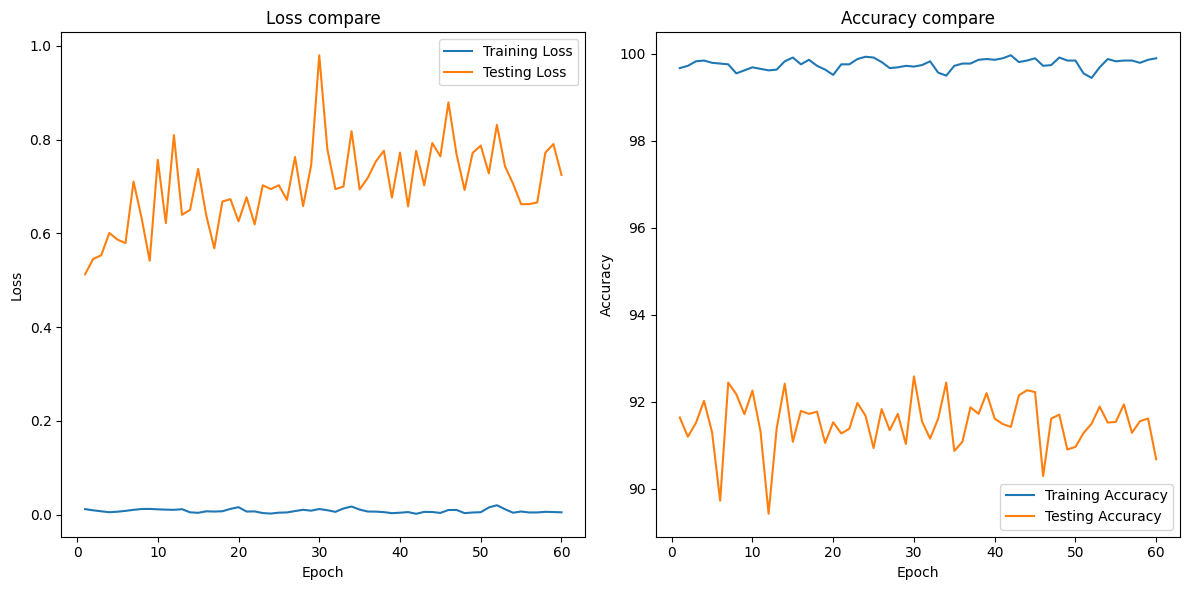

In [43]:
import matplotlib.pyplot as plt
import json

n_epochs = len(running_loss_list)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(np.arange(1, n_epochs + 1), running_loss_list, label='Training Loss')
ax[0].plot(np.arange(1, n_epochs + 1), testing_loss_list, label='Testing Loss')
ax[0].set_title('Loss compare')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(np.arange(1, n_epochs + 1), running_accu_list, label='Training Accuracy')
ax[1].plot(np.arange(1, n_epochs + 1), testing_accu_list, label='Testing Accuracy')
ax[1].set_title('Accuracy compare')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()

# figname = f'{os.path.dirname(savepath)}/{model_name}_loss.png'
# if os.path.isfile(figname):
#   print(f"{figname} exist.")
# else:
#   plt.savefig(figname)
plt.show()

lossname = f'{os.path.dirname(savepath)}/{model_name}_loss.json'
data_to_save = {
    'running_loss_list': running_loss_list,
    'testing_loss_list': testing_loss_list,
    'running_accu_list': running_accu_list,
    'testing_accu_list': testing_accu_list
}

with open(lossname, 'a') as f:
    json.dump(data_to_save, f, indent=4)

# 儲存模型參數



In [ ]:
filename = save_model(model)

params = {
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'learning_rate': lr,
}

if os.path.isfile(filename+'.json'):
    print(f"{filename}.json exist.")
else:
    with open(f'{filename}.json', 'w') as f:
        json.dump(params, f)

# 讀取模型參數

In [ ]:
model = pretrained_model
model = model.to(device)

In [ ]:
import json
filename = input("請輸入要獲取模型路徑:")

if not os.path.isfile(filename+'.pth'):
    print(f"{filename}.pth not exist.")
else:
    print(model.load_state_dict(torch.load(filename+'.pth')))

if os.path.isfile(filename+'.json'):
  with open(f'{filename}.json', 'r') as f:
      params = json.load(f)

# 評估


In [ ]:
# 評估設置
try:
  batch_size = params['batch_size']
except:
  batch_size = int(input("batch_size:"))
print(batch_size)

dataset = CustomDataset(images_train, labels_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [ ]:
criterion = nn.BCELoss()
valid_loss, valid_accuracy, predict_list = valid(dataloader, model, criterion, device)
print(f"Accuracy of the network on the test images: {valid_accuracy}%")
print(f"Loss: {valid_loss}")
predict_listq = predict_list.cpu()


Accuracy of the network on the 15592   
training images: 99.20472036942022%  
Loss: 0.03187363331013983


In [ ]:
print_results(predict_listq, labels)

# Test

images讀進來是疊在一起的。 需要info紀錄images檔名順序與分割情況

In [ ]:
testdir = "Cropped_60-316_150-406_11-71/Test_Image_cropped"

In [ ]:
from google.auth.transport.requests import Request
request = Request()
credentials.refresh(request)
loop.run_until_complete(get_data_disk_async(drive_rootdir, testdir,token = credentials.token))

In [ ]:
images_test, info = read_test(testdir,termi=200,shift=0)

In [ ]:
images_test.shape

In [ ]:
%reset_selective images_test

In [ ]:
try:
  batch_size = params['batch_size']
except:
  batch_size = int(input("batch_size:"))
print(batch_size)

dataset = CustomDataset(images_test, None, mode='test')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


In [ ]:
model.eval()

predict_list = torch.tensor([]).to(device)
with torch.no_grad():  # 不更新梯度
    for j, batch_images in enumerate(dataloader):
        batch_images = batch_images.to(device)
        outputs = model(batch_images)
        predicted = (outputs.squeeze() > 0.5).int()

        # if predicted.dim() == 0:
        #   predicted = predicted.unsqueeze(0)
        predict_list = torch.cat((predict_list,predicted),0)


predict_listq = predict_list.cpu()

In [ ]:
predict_listq.sum()

# 輸出至submission.csv

In [29]:
dflable = read_label(labelpath)

In [35]:
pattern = re.compile(r'.*_[0-9]+$')  # 正則表達式匹配 "_數字" 結尾
mask = dflable.index.str.match(pattern)
scan_guess = np.array(dflable[mask]['label'])

訓練過程不改變資料順序, 所以輸出順序同輸入.   
predict值跟隨images順序, 照著info把每個predict值(label)與檔名(id)對上. 輸出成提交格式

In [ ]:
def yes(predict):
  return int(sum(predict) >= 3)



predict_list = predict_listq.numpy()

## 還原id與對應label，假設key按照scan輸入順序排列,每個key對應的scan的cuts數是nslice
output = {}
k = 0  #第幾個scan
ii = 0   #每個key輪到第幾個
id, nslice = info[k][0], info[k][1]
for i in range(len(predict_list)):

  if (ii >= nslice):
    #該換下一個scan了
    output[id] = yes(predict_list[i-nslice:i]) #評估方式

    k += 1
    ii = 0
    id, nslice = info[k][0], info[k][1]

  label = predict_list[i]
  output[id+f'_{ii}'] = int(predict_list[i])
  ii += 1

output[id] = yes(predict_list[(i+1)-ii:]) #補上最後一個scan評估
# import pdb
# pdb.set_trace()
output = list(output.items())
dfout = pd.DataFrame(output)
dfout.columns = ['id', 'label']
dfout = dfout.sort_values(by='id', key=lambda x: x.map(custom_sort_key))
filename = input("輸入提交路徑(default for submission)")
if filename == '':
  filename = 'submission'
dfout.to_csv(f"{filename}"+'.csv', index=False)

In [ ]:
info

In [ ]:
dfout

# 查看submission.csv

In [ ]:
!pwd

In [ ]:
dftest = read_submission('fisrt_80.csv')
# dftest = read_submission('submission.csv')
dflabel = read_label("TrainValid_ground_truth.csv")

In [ ]:
len(dftest)

In [ ]:
import re


# 抓出scan-level data
pattern = re.compile(r'.*_[0-9]+$')  # 正則表達式匹配 "_數字" 結尾
mask = ~dftest.index.str.match(pattern)
scan_guess = np.array(dftest[mask]['label'])
scan_truth = np.array(dflabel.loc[dftest[mask]['label'].index]['label'])

mask = ~mask
cut_guess = np.array(dftest[mask]['label'])
cut_truth = np.array(dflabel.loc[dftest[mask]['label'].index]['label'])

In [ ]:
ss = 10
print("="*ss + "F1 score on scan level" + "="*ss)
print_results(scan_guess, scan_truth)
print(),print()
print("="*ss + "F1 score on cut level" +"="*ss )
print_results(cut_guess, cut_truth)

# 其他指令
不在工作流
當參考

In [ ]:
import time
datadir = 'Train_Valid_Image'
for idx, afile in enumerate(os.listdir(datadir)):
  file_path = os.path.join(datadir, afile)
  time.sleep(1)
  nii_file =  nib.load(file_path)
  print(f"{idx}: read {afile}")

In [ ]:
pattern = re.compile(r'.*_[0-9]+$')  # 正則表達式匹配 "_數字" 結尾
mask = dftest.index.to_series().str.match(pattern)
dflabel_ = dftest[mask]
dflabel_.index.map(lambda x : x.split('_')[1]).sort_values()[-3:]

In [ ]:
import random

# 假設這是您的列表
my_list = np.array([1, 2, 3, 4])

mask = [True, False, False, True]
my_list[mask]

In [ ]:
datadir ="TrainValid_Image/train_data"
labelpath = 'TrainValid_ground_truth.csv'
labels_ = read_label(labelpath)


filelist = os.listdir(datadir)
filelist = filelist[10:20]
selecteds = [labels_.loc[labels_.index.str.startswith(afile.strip('.nii')+'_')] for afile in filelist]
scans_info = []
# preallocated
print("enter")
numcuts = [len(selected) for selected in selecteds]
numcut = sum(numcuts)

In [ ]:
numcuts = [len(selected) for selected in selecteds]

In [ ]:
img = nib.load('Train_Valid_Image/Zx00AD16F8B97A53DE6E7CFE260BDF122F0E655659A3DF1628.nii.gz')


In [ ]:
drive.flush_and_unmount()

In [ ]:
t1 = torch.randint(3,(5,1,2,2))
lab = torch.tensor([1,1,1,1,1])
t1

In [ ]:
remove_positive_images(t1,lab,0.79)

In [ ]:
!pip install -U --no-cache-dir gdown gdown

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
!gdown https://drive.google.com/drive/folders/1C7HXpHMw1Alvwif9hO97FUzfn4rhxG8B -O Train_Valid_Image --folder --remaining-ok

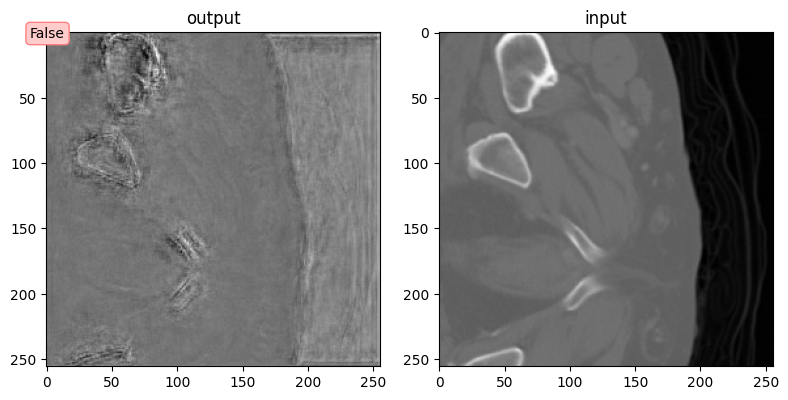

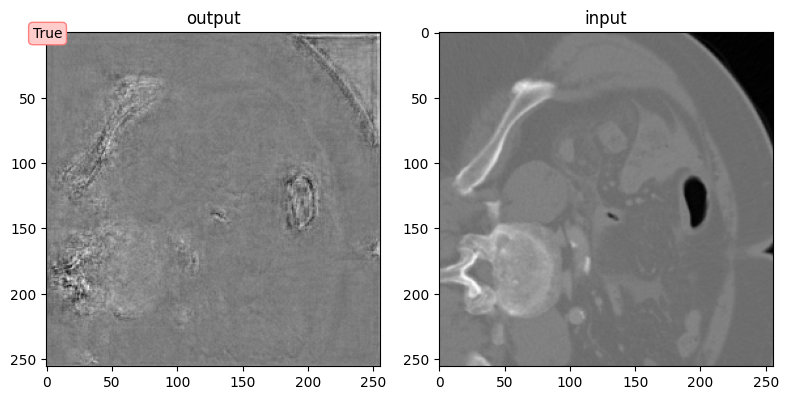

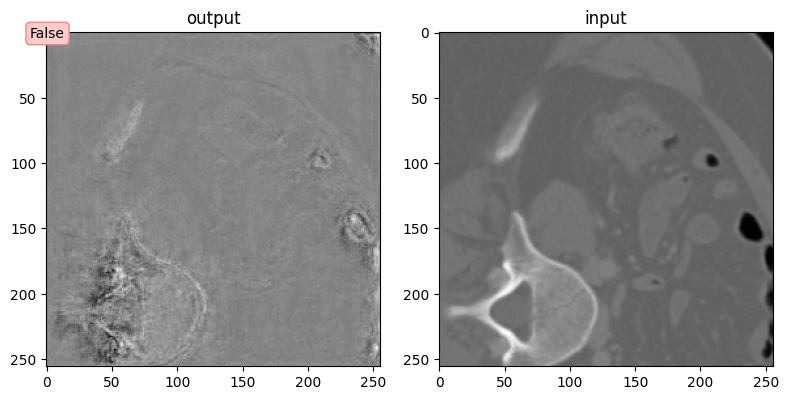

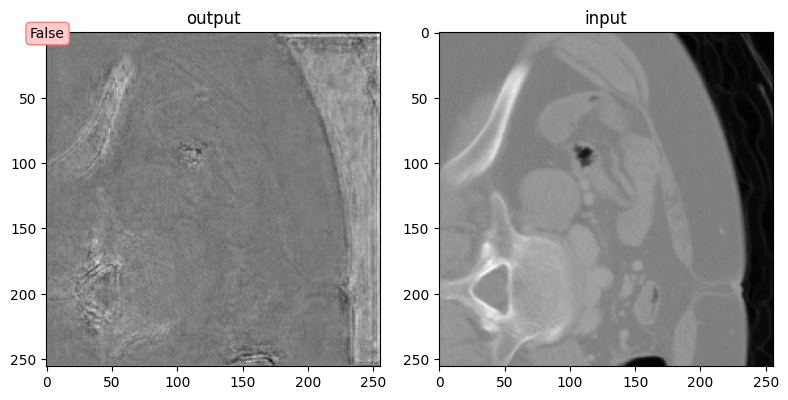

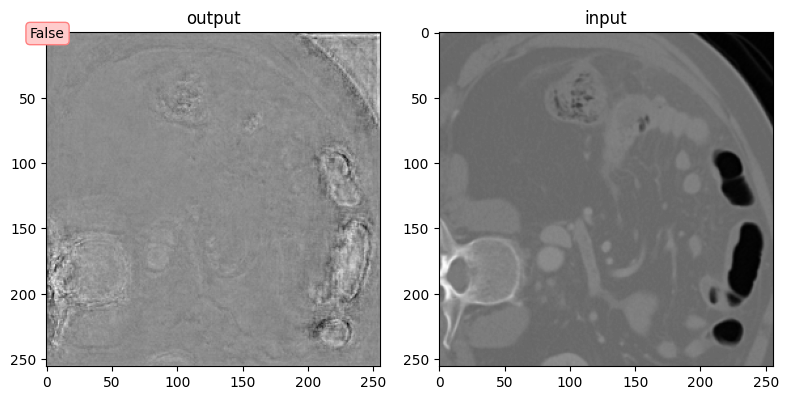

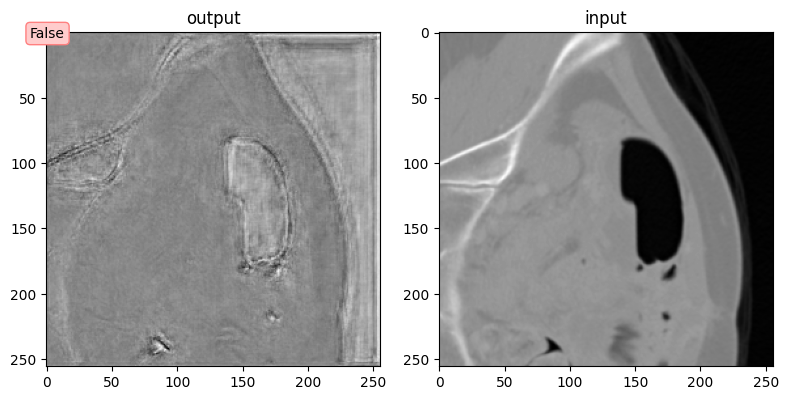

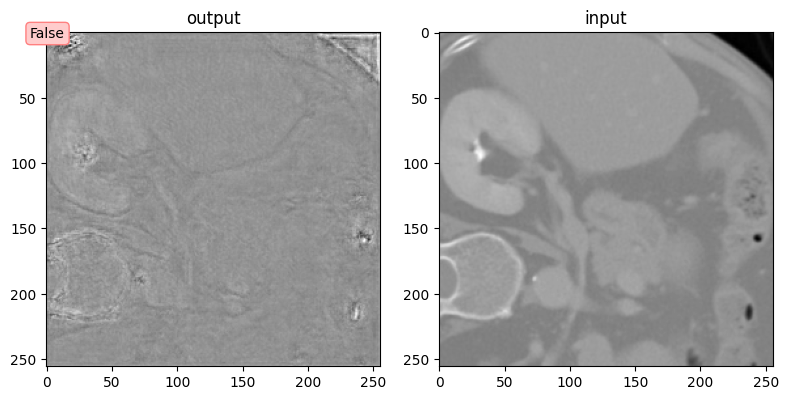

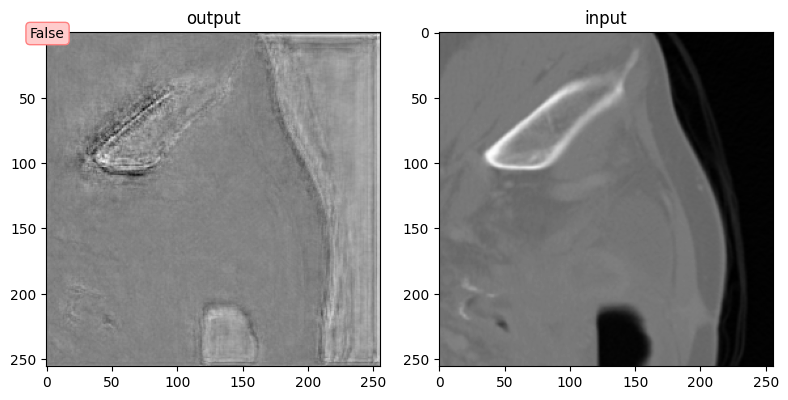

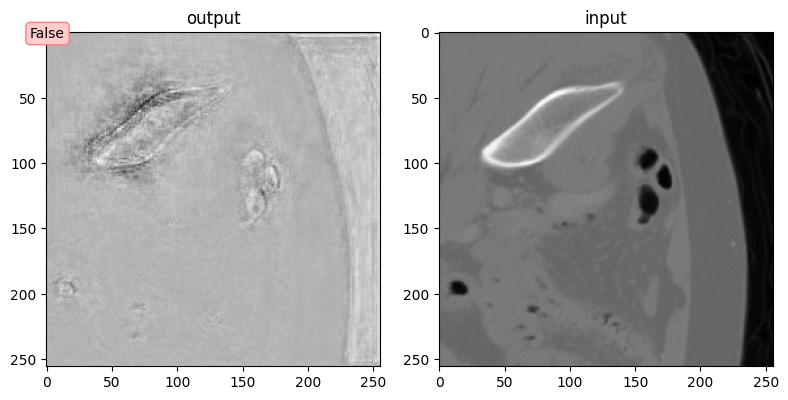

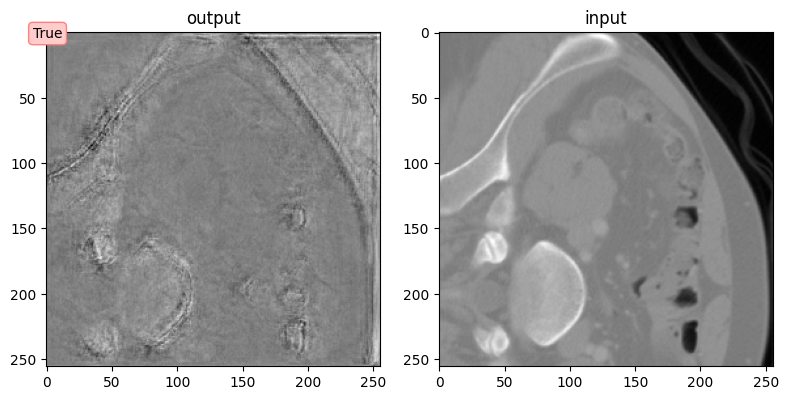

In [149]:
import matplotlib.pyplot as plt
num_epochs = 1
batch_size = 16
lr = 0.01
droprate = 0.8
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr)

images_train, labels_train = remove_false_images(images, labels, droprate)
dataset = CustomDataset(images_train, labels_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)

for epoch in range(start, num_epochs):
  model.train()
  running_loss = 0.0
  correct_count = 0
  total_count = 0

  for batch_images, batch_labels in dataloader:
      batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
      optimizer.zero_grad()
      outputs = model(batch_images).squeeze()
      # loss = criterion(outputs, batch_labels)
      # loss.backward()
      # optimizer.step()

      fig, ax = plt.subplots(1, 2, figsize=(8, 6))

      ax[0].imshow(outputs[0].detach().numpy(),cmap='gray')
      ax[0].set_title('output')
      if batch_labels[0]:
        ax[0].text(0.6, 0.7, "True", size=10,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )
      else:
        ax[0].text(0.6, 0.7, "False", size=10,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )
      ax[1].imshow(batch_images[0].squeeze().detach().numpy(),cmap='gray')
      ax[1].set_title('input')


      plt.tight_layout()
      plt.show()
      # running_loss += loss.item()
      # predicted = (outputs > 0.5).int()
      # correct_count += (predicted == batch_labels).sum().item()
      # total_count += batch_labels.size(0)

  # epoch_loss = running_loss / len(dataloader)
  # epoch_accuracy = correct_count / total_count

